In [1]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np

import seaborn as sb
import scikitplot
from matplotlib import pyplot as plotGraph
from sklearn.metrics import classification_report, accuracy_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.utils as np_utils
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# get data
rafDB_df = pd.read_csv("/content/drive/MyDrive/17644_MoodDetectives/Datasets/rafDB.csv")

# print number of images and display first 5 rows in dataframe
print("Number of images: ", len(rafDB_df))

rafDB_df.head(5)

Number of images:  15339


,emotion,pixels
0,4,19 33 59 102 106 92 80 67 59 89 117 120 88 57 ...
1,0,81 70 53 56 50 45 47 39 49 68 90 101 78 56 62 ...
2,3,152 152 146 150 158 155 136 122 106 97 88 94 1...
3,0,110 118 124 131 140 147 149 152 158 161 164 16...
4,4,19 18 14 26 52 69 81 90 98 107 112 113 129 135...


In [5]:
# number of unique emotions in dataset
rafDB_df.emotion.value_counts()

3    5957
6    3204
4    2460
0    1619
2     877
5     867
1     355
Name: emotion, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

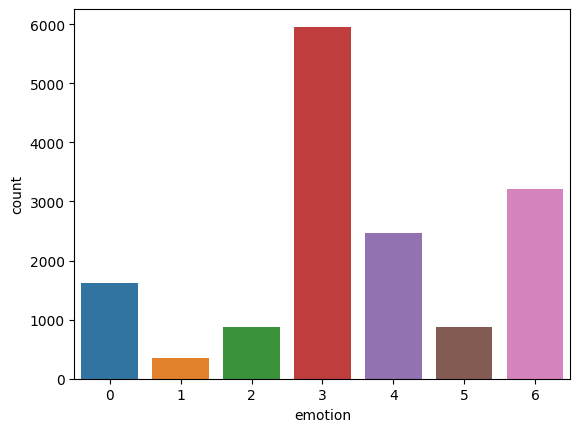

In [6]:
sb.countplot(x=rafDB_df.emotion)

In [7]:
emotion_labels = {
    0: "suprise",
    1: "fear",
    2: "disgust",
    3: "happy",
    4: "sad",
    5: "anger",
    6: "neutral"
}

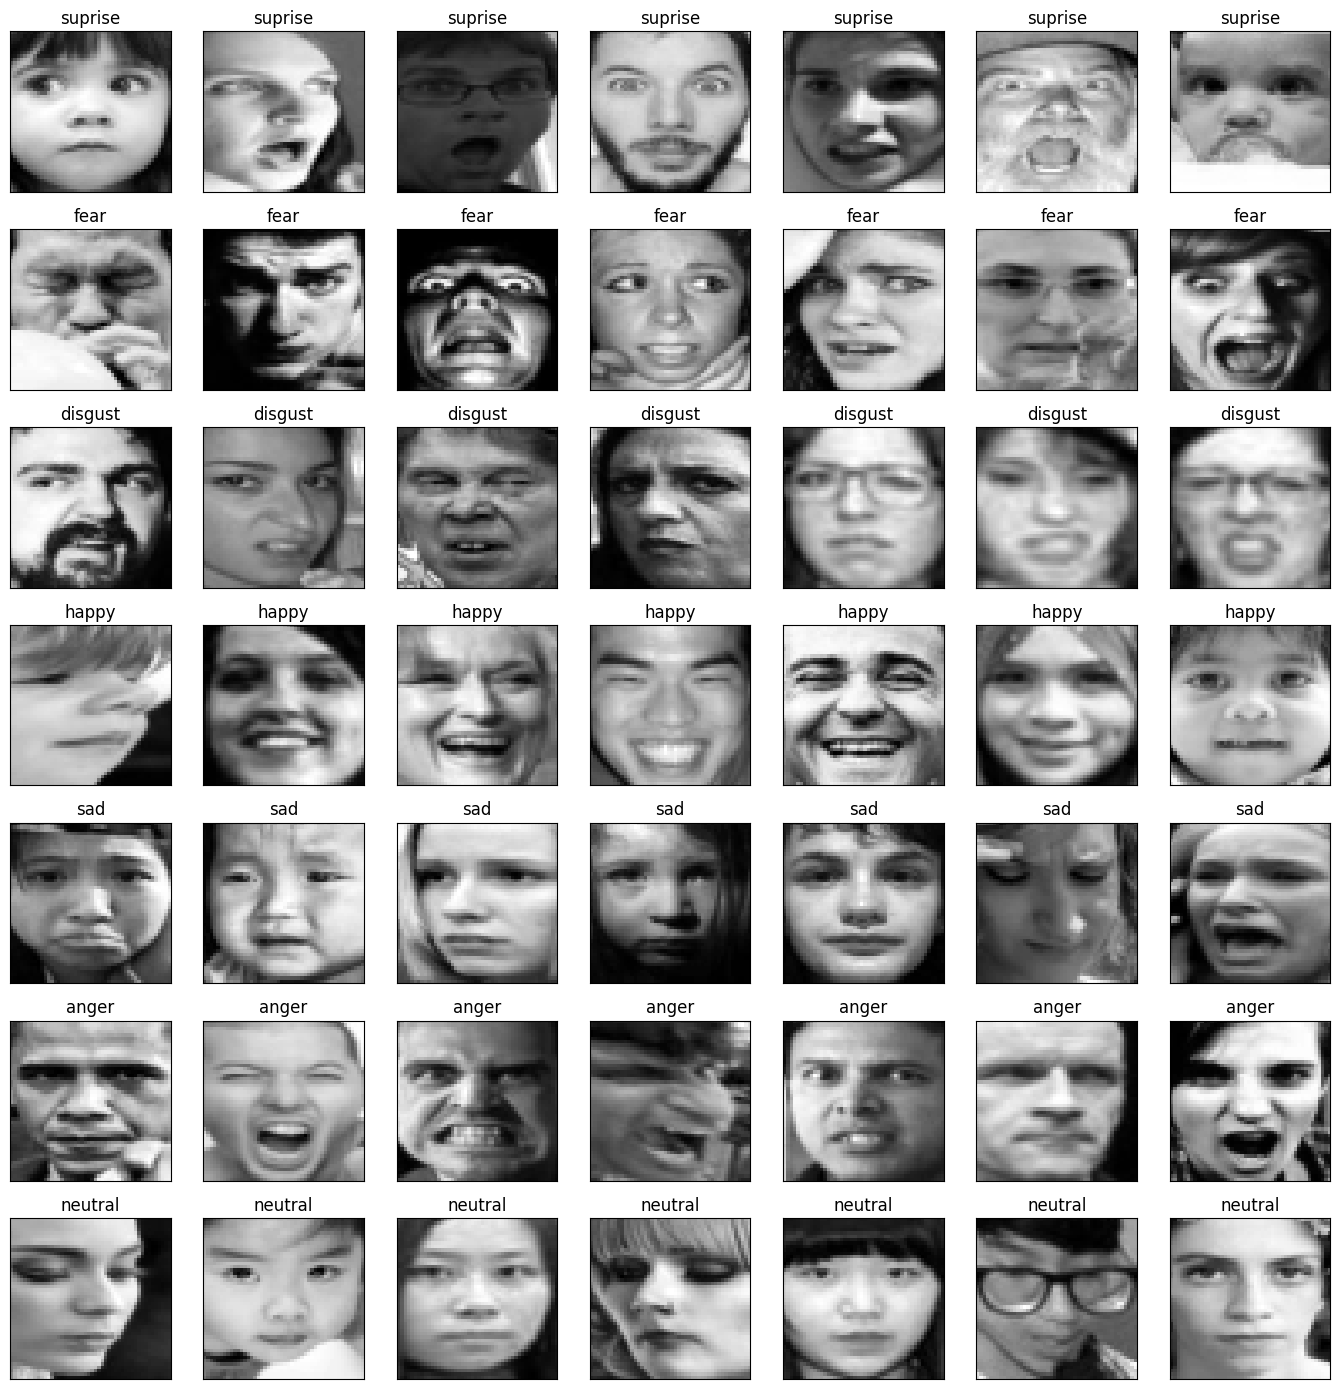

In [8]:
# display example images for each emotion in dataset
fig = plotGraph.figure(1,(14,14))

k = 0

for label in sorted(rafDB_df.emotion.unique()):
  for j in range(7):
    px = rafDB_df[rafDB_df.emotion == label].pixels.iloc[j]
    px = np.array(px.split(" ")).reshape(48,48).astype("float32")

    k += 1

    ax = plotGraph.subplot(7,7,k)
    ax.imshow(px, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(emotion_labels[label])
    plotGraph.tight_layout()

In [9]:
img_array = rafDB_df.pixels.apply(lambda x:
                                    np.array(x.split(" ")).reshape(48,48,1).astype(
                                        "float32"))

img_array = np.stack(img_array, axis=0)

img_array.shape

(15339, 48, 48, 1)

In [10]:
rafDB_df.emotion

0        4
1        0
2        3
3        0
4        4
        ..
15334    6
15335    6
15336    6
15337    6
15338    6
Name: emotion, Length: 15339, dtype: int64

In [11]:
le = LabelEncoder()
img_labels = le.fit_transform(rafDB_df.emotion)
img_labels = np_utils.to_categorical((img_labels))
img_labels.shape

(15339, 7)

In [12]:
img_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

# Train Model (CNN)

In [13]:
# split data into train and test data

x_Train, x_Test, y_Train, y_Test = train_test_split(
    img_array,
    img_labels,
    shuffle=True,
    stratify = img_labels,
    test_size = .2,
    random_state=42
)

In [14]:
# normalize data
x_Train = x_Train/255
x_Test = x_Test/255

In [15]:
img_width = x_Train.shape[1]
img_height = x_Train.shape[2]
img_depth = x_Train.shape[3]

num_classes = y_Train.shape[1]

In [16]:
# build model

def buildnet(optim):
  net = Sequential(name="Seven_Emotion_CNN")

  net.add(
      Conv2D(
          filters=64,
          kernel_size=(5,5),
          input_shape = (img_width, img_height, img_depth),
          activation = "relu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_1"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_1"))

  net.add(
      Conv2D(
          filters=64,
          kernel_size=(5,5),
          activation = "relu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_2"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_2"))
  net.add(MaxPooling2D(pool_size=(2,2), name="maxpool2d_1"))
  net.add((Dropout(0.4, name="dropout_1")))

  net.add(
      Conv2D(
          filters=128,
          kernel_size=(3,3),
          activation = "relu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_3"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_3"))

  net.add(
      Conv2D(
          filters=128,
          kernel_size=(3,3),
          activation = "relu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_4"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_4"))
  net.add(MaxPooling2D(pool_size=(2,2), name="maxpool2d_2"))
  net.add((Dropout(0.4, name="dropout_2")))

  net.add(
      Conv2D(
          filters=256,
          kernel_size=(3,3),
          activation = "relu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_5"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_5"))

  net.add(
      Conv2D(
          filters=256,
          kernel_size=(3,3),
          activation = "relu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_6"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_6"))
  net.add(MaxPooling2D(pool_size=(2,2), name="maxpool2d_3"))
  net.add((Dropout(0.5, name="dropout_3")))

  net.add(Flatten(name = "flatten"))

  net.add(
      Dense(
          128,
          activation = "relu",
          kernel_initializer = "he_normal",
          name = "dense_1"

      )
  )

  net.add(BatchNormalization(name="batchnorm_7"))
  net.add(Dropout(0.6, name="dropout_4"))

  net.add(
      Dense(
          num_classes,
          activation = "softmax",
          kernel_initializer = "he_normal",
          name = "outter_layer"
      )
  )

  net.compile(
      loss="categorical_crossentropy",
      optimizer= optim,
      metrics = ["accuracy"]
  )

  net.summary()

  return net


In [17]:
batch_size = 32
epochs = 100
steps_per_epoch = len(x_Train)/batch_size

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = 0.00005,
    patience = 11,
    verbose =1,
    restore_best_weights = True
    )

lr_scheduler = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 7,
    min_lr = 1e-7,
    verbose = 1

)

google_path ="/content/drive/MyDrive/17644_MoodDetectives/23_Layer_CNN_Model/Seven_Emotions/RAFDb/Checkpoints/"
model_checkpoints = ModelCheckpoint(
    filepath = google_path + "cnn_raf_model_epoch{epoch}.h5",
    save_weights_only=False,
    save_freq = int(5* steps_per_epoch), # save model every 5 epochs
    # monitor = "val_accuracy",
    verbose = 1
    
)

callbacks = [
    early_stopping,
    lr_scheduler,
    model_checkpoints
]

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True
)

train_datagen.fit(x_Train)

In [19]:
optims = [
    optimizers.Nadam(
        learning_rate = .001,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-07,
        name = "Nadam"
    ),
    optimizers.Adam(0.001),
]

In [20]:
model = buildnet(optims[1])

history = model.fit_generator(
    train_datagen.flow(x_Train, y_Train, batch_size = batch_size),
    validation_data = (x_Test, y_Test),
    steps_per_epoch = len(x_Train)/batch_size,
    epochs = epochs,
    callbacks = callbacks,
    use_multiprocessing = True
)
              

Model: "Seven_Emotion_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)  

<ipython-input-20-ad9034b8d9d3>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


383/383 [==============================] - 23s 37ms/step - loss: 2.0863 - accuracy: 0.3135 - val_loss: 1.9538 - val_accuracy: 0.4482 - lr: 0.0010
Epoch 2/100
383/383 [==============================] - 14s 35ms/step - loss: 1.7040 - accuracy: 0.3942 - val_loss: 1.3668 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 3/100
383/383 [==============================] - 13s 34ms/step - loss: 1.5006 - accuracy: 0.4563 - val_loss: 1.2778 - val_accuracy: 0.5287 - lr: 0.0010
Epoch 4/100
383/383 [==============================] - 13s 33ms/step - loss: 1.4646 - accuracy: 0.4582 - val_loss: 1.3281 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 5/100
380/383 [============================>.] - ETA: 0s - loss: 1.3664 - accuracy: 0.5032
Epoch 5: saving model to /content/drive/MyDrive/17644_MoodDetectives/23_Layer_CNN_Model/Seven_Emotions/RAFDb/Checkpoints/cnn_raf_model_epoch5.h5
383/383 [==============================] - 14s 36ms/step - loss: 1.3668 - accuracy: 0.5027 - val_loss: 1.1739 - val_accuracy: 0.5756 - lr:

# Evaluate Model

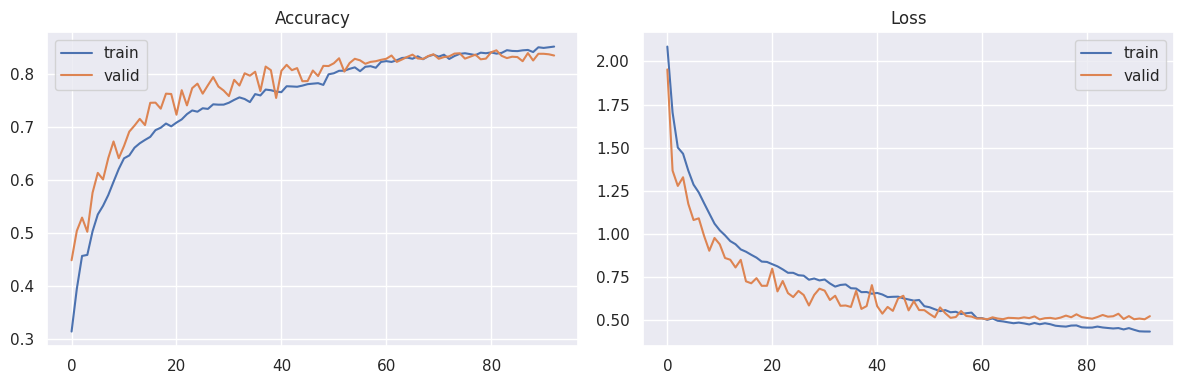

In [21]:
# metrics

sb.set()
figure = plotGraph.figure(0, (12,4))

# Plot Accuracy
ax = plotGraph.subplot(1,2,1)
sb.lineplot(
    x = history.epoch,
    y = history.history["accuracy"], 
    label="train"
)

sb.lineplot(
    x = history.epoch,
    y = history.history["val_accuracy"], 
    label="valid"
)

plotGraph.title("Accuracy")
plotGraph.tight_layout()

# Plot Loss
ax = plotGraph.subplot(1,2,2)
sb.lineplot(
    x = history.epoch,
    y = history.history["loss"], 
    label="train"
)

sb.lineplot(
    x = history.epoch,
    y = history.history["val_loss"], 
    label="valid"
)

plotGraph.title("Loss")
plotGraph.tight_layout()

In [22]:
# acccuracy

prediction = model.predict(x_Test)

accuracy_score( np.argmax(y_Test,axis=1) , np.argmax(prediction, axis =1) )

96/96 [==============================] - 1s 6ms/step


0.8445241199478487

96/96 [==============================] - 1s 5ms/step


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

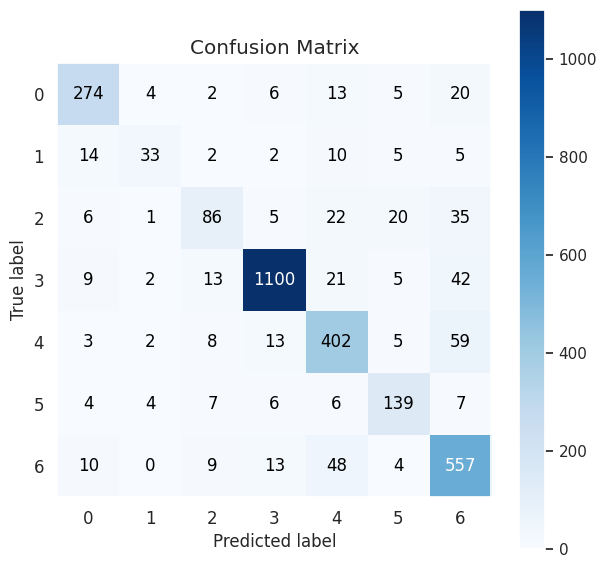

In [23]:
# Confusion Matrix

predictions = model.predict(x_Test)
class_predictions = np.argmax(predictions, axis=1)

scikitplot.metrics.plot_confusion_matrix(
    np.argmax(y_Test, axis=1),
    class_predictions,
    figsize=(7,7)
)

In [24]:
print(
    "Total Wrong Predictions:", 
      np.sum(
          np.argmax(y_Test, axis=1) != class_predictions
      )
    )

print(
    classification_report(
    np.argmax(y_Test, axis=1), class_predictions
    )
  )

Total Wrong Predictions: 477
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       324
           1       0.72      0.46      0.56        71
           2       0.68      0.49      0.57       175
           3       0.96      0.92      0.94      1192
           4       0.77      0.82      0.79       492
           5       0.76      0.80      0.78       173
           6       0.77      0.87      0.82       641

    accuracy                           0.84      3068
   macro avg       0.79      0.74      0.76      3068
weighted avg       0.85      0.84      0.84      3068



1/1 [==============================] - 0s 20ms/step


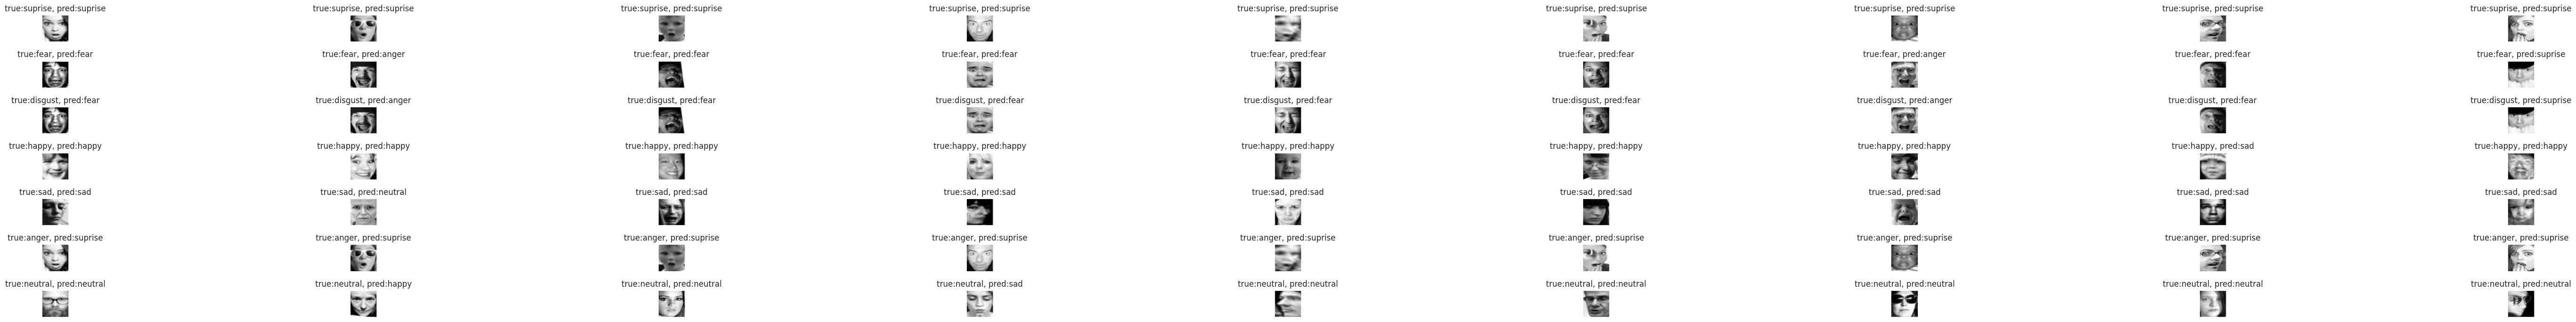

In [25]:
# check some images model got wrong
figure = plotGraph.figure(1, (63,7))

map_emotions ={
    0: "suprise",
    1: "fear",
    2: "disgust",
    3: "happy",
    4: "sad",
    5: "anger",
    6: "neutral"
}

np.random.seed(2)

random_suprise_images = np.random.choice(
    np.where(y_Test[:,0] == 1)[0],
    size=9
)

random_fear_images = np.random.choice(
    np.where(y_Test[:,1] == 1)[0],
    size=9
)
  

random_disgust_images = np.random.choice(
    np.where(y_Test[:,2]==1)[0],
    size=9
    )

random_happy_images = np.random.choice(
    np.where(y_Test[:,3] == 1)[0],
    size=9
)

random_sad_images = np.random.choice(
    np.where(y_Test[:,4] == 1)[0],
    size=9
)
  

random_anger_images = np.random.choice(
    np.where(y_Test[:,5]==1)[0],
    size=9
    )

random_neutral_images = np.random.choice(
    np.where(y_Test[:,6]==1)[0],
    size=9
    )

for i, (suprise_index, 
        fear_index, 
        disgust_index,
        happy_index,
        sad_index,
        anger_index,
        neutral_index) in enumerate(zip(random_suprise_images, 
                                        random_fear_images, 
                                        random_disgust_images,
                                        random_happy_images,
                                        random_sad_images,
                                        random_anger_images,
                                        random_neutral_images)):
  ax = plotGraph.subplot(7,9, i+1)
  sample_image = x_Test[suprise_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])
  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:suprise, pred:{map_emotions[sample_class_prediction]}")
  

  ax = plotGraph.subplot(7,9, i+10)
  sample_image = x_Test[fear_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:fear, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(7,9, i+19)
  sample_image = x_Test[fear_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:disgust, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(7,9, i+28)
  sample_image = x_Test[happy_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:happy, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(7,9, i+37)
  sample_image = x_Test[sad_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:sad, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(7,9, i+46)
  sample_image = x_Test[suprise_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:anger, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(7,9, i+55)
  sample_image = x_Test[neutral_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:neutral, pred:{map_emotions[sample_class_prediction]}")

plotGraph.tight_layout()



# Save Model

In [27]:
# save model
model.save(
    "/content/drive/MyDrive/17644_MoodDetectives/23_Layer_CNN_Model/Seven_Emotions/RAFDb/cnn_raf_model.h5"
    )

# model.save(
#     "cnn_raf_model.h5"
#     )